In [1]:
import os
import pandas as pd
pasta_mestrado = 'E:/mestrado/Pesquisa/Dados simulados'
redes = ['CNN', 'LSTM']
caminho_var = f'{pasta_mestrado}/resultados VAR.csv'
steps_ahead_list = [1, 5, 20]

In [2]:
datasets = {}
paths = {}
for rede in redes:
    datasets[rede] = {}
    paths[rede] = {}
    data_indices = set()
    for steps_ahead in steps_ahead_list:
        paths[rede][steps_ahead] = f'{pasta_mestrado}/Saída da otimização de hiperparâmetros {rede}/{steps_ahead} steps ahead'
        current_data_indices = set(os.listdir(paths[rede][steps_ahead]))
        if data_indices == set():
            data_indices = current_data_indices
        else:
            data_indices = data_indices.intersection(current_data_indices)
        datasets[rede][steps_ahead] = pd.DataFrame()
    for data_index in data_indices:
        for steps_ahead in steps_ahead_list:
            current_df = pd.read_csv(f'{paths[rede][steps_ahead]}/{data_index}/opt_hist.csv')
            current_df['data_set_index'] = data_index
            datasets[rede][steps_ahead] = pd.concat([datasets[rede][steps_ahead], current_df])
            del current_df

In [3]:
datasets

{'CNN': {1:     win_size  filters_conv_1  kernel_size_conv_1[0]  kernel_size_conv_1[1]  \
  0         65              46                     15                      5   
  1         73              22                     14                      1   
  2        101              34                     23                      2   
  3        110              46                     29                      4   
  4        120              27                     28                      5   
  ..       ...             ...                    ...                    ...   
  95       119              18                     24                      1   
  96       120              14                     25                      1   
  97       110              17                     24                      1   
  98       115              19                     24                      1   
  99       111              19                     23                      1   
  
     activation_conv_1  poo

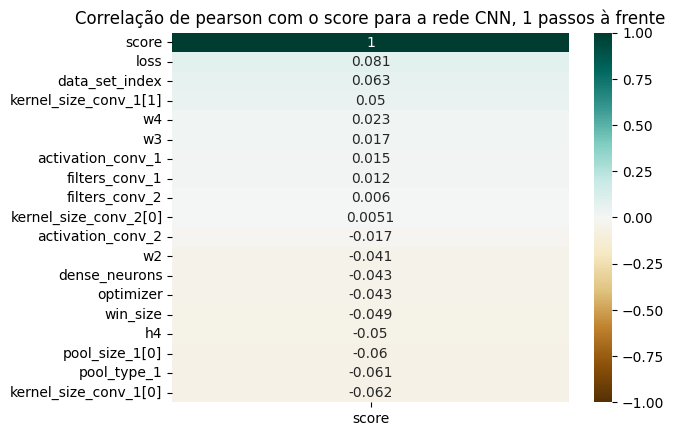

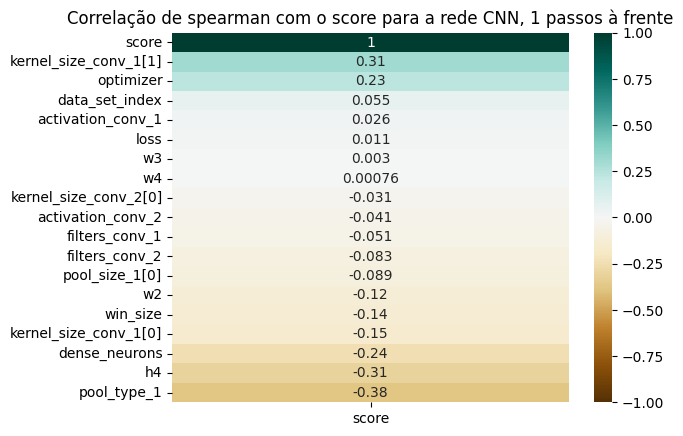

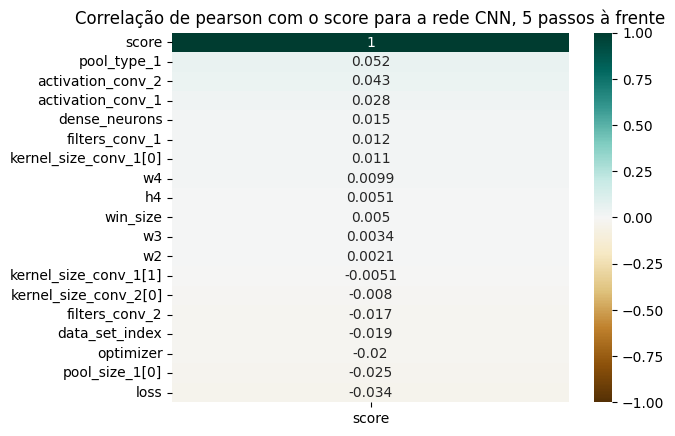

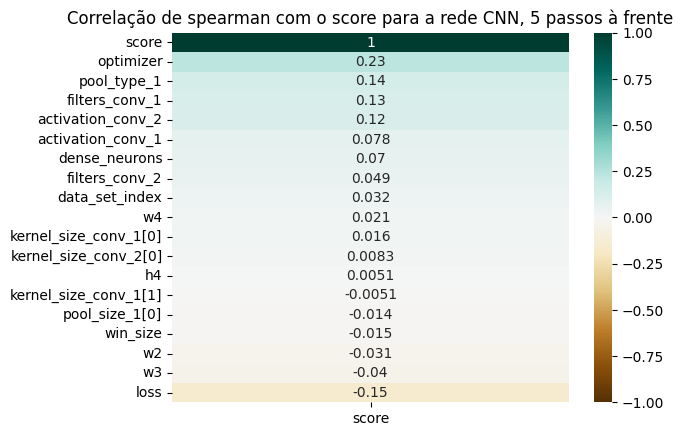

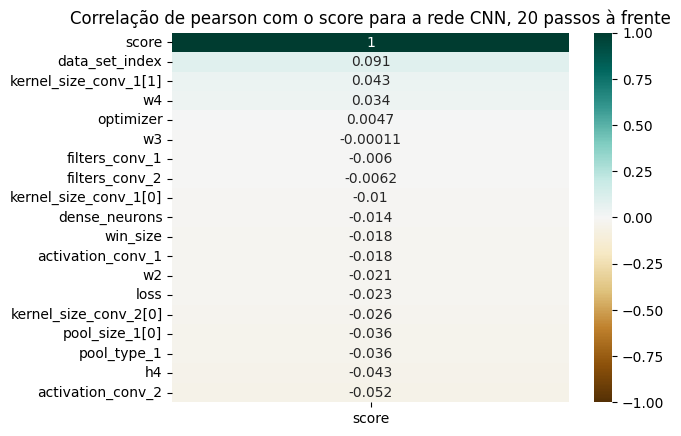

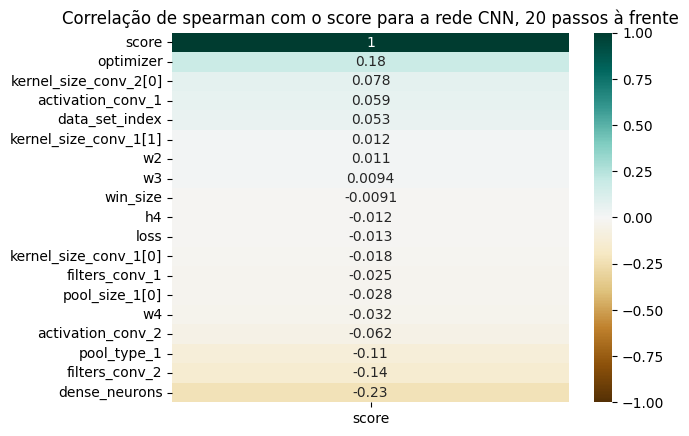

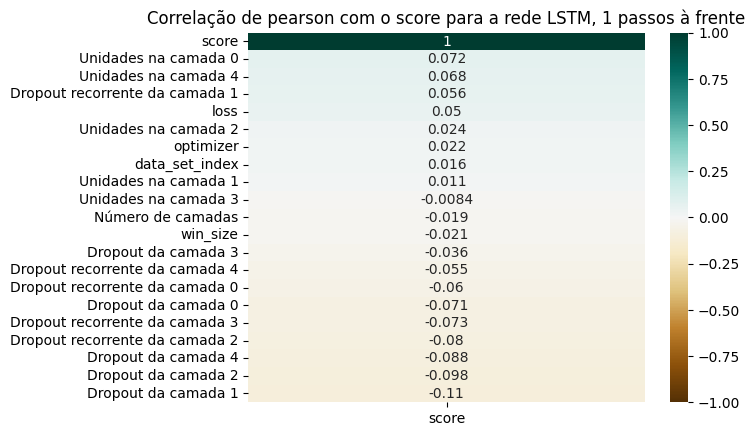

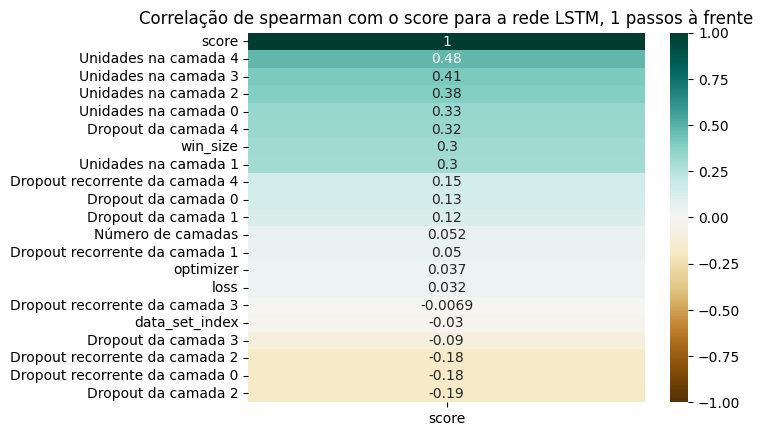

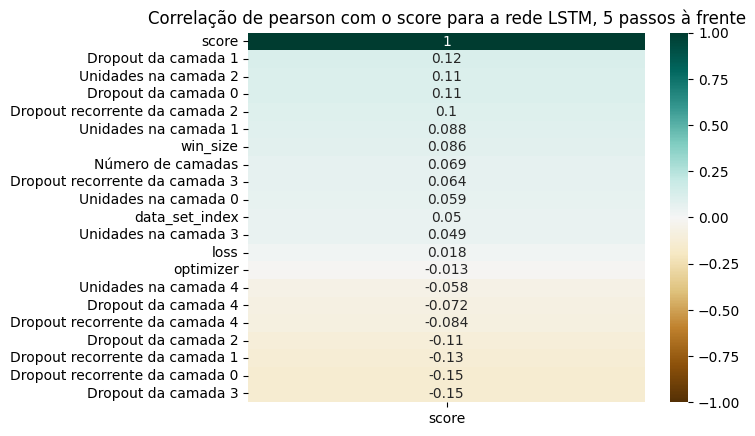

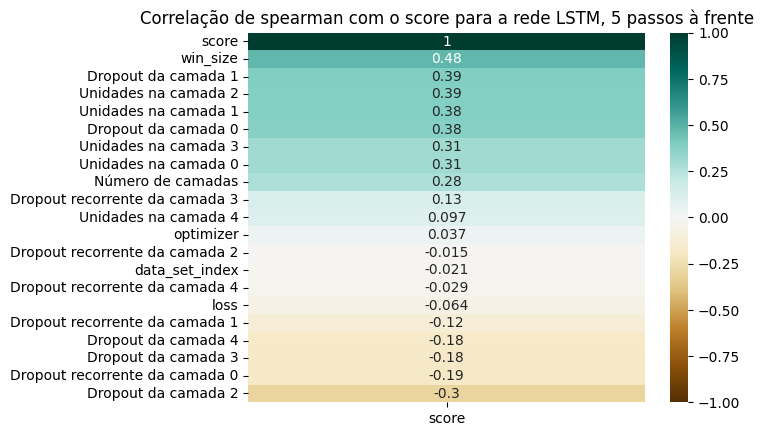

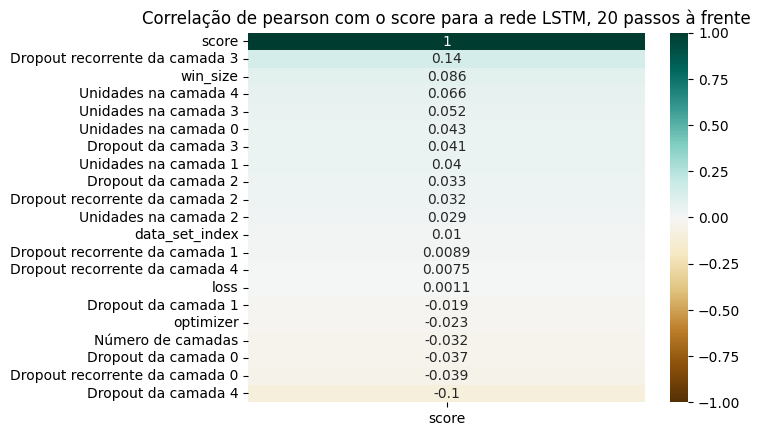

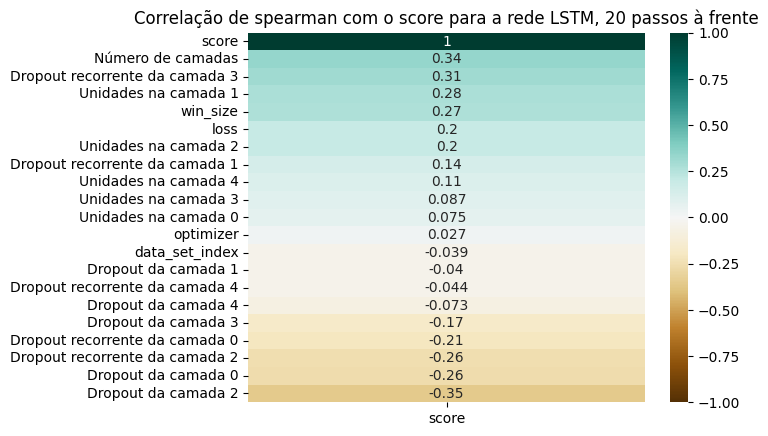

In [4]:
import seaborn as sns
from matplotlib import pyplot as plt
correlations = ['pearson', 'spearman']
for rede in redes:
    for steps_ahead in steps_ahead_list:
        df_encoded = datasets[rede][steps_ahead].apply(lambda col: col.map(lambda x: list(col.values).index(x)) if col.dtype == 'object' else col, axis=0)
        for correlation in correlations:
            plt.figure()
            heatmap = sns.heatmap(df_encoded.corr(method=correlation)[['score']].sort_values(by='score', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
            heatmap.set_title(f'Correlação de {correlation} com o score para a rede {rede}, {steps_ahead} passos à frente')
            plt.show()

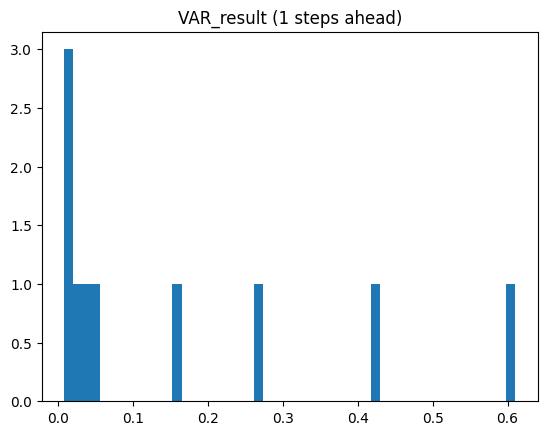

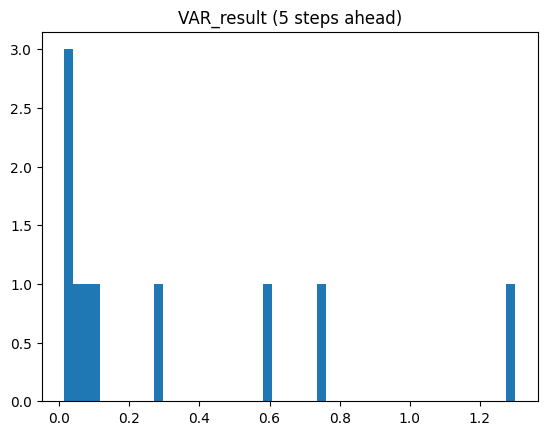

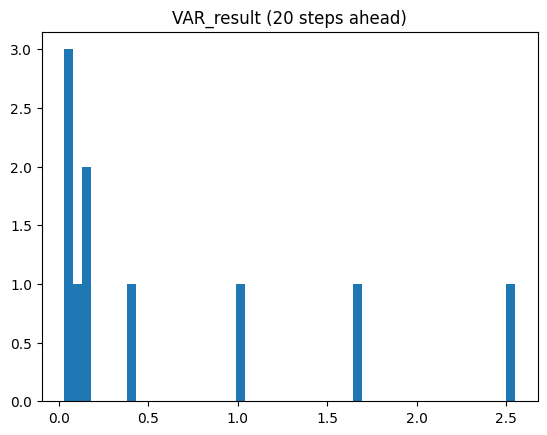

In [5]:
var_df = pd.read_csv(caminho_var)
data_indices = list(var_df['Data_index'].values)
for c in var_df.columns:
    if c != 'Data_index':
        plt.figure()
        plt.title(c)
        plt.hist(var_df[c], bins=50)
        plt.show()

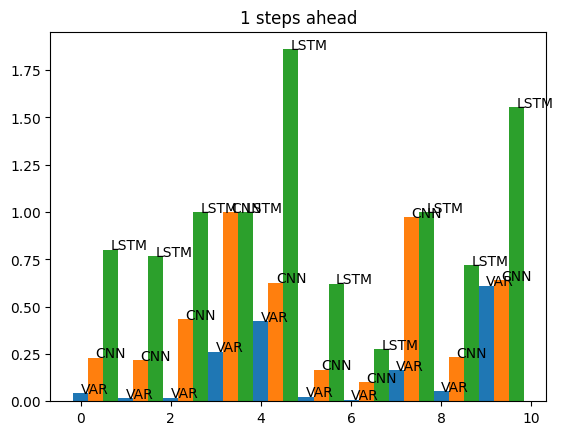

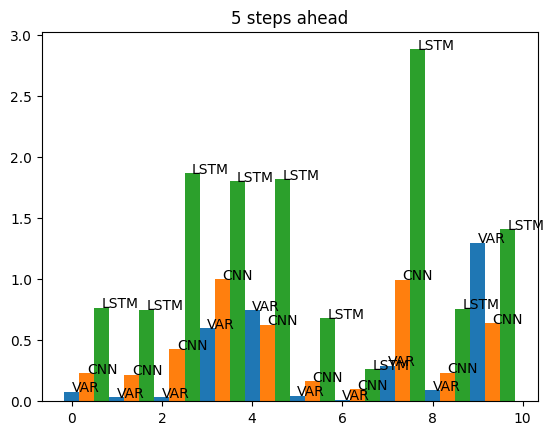

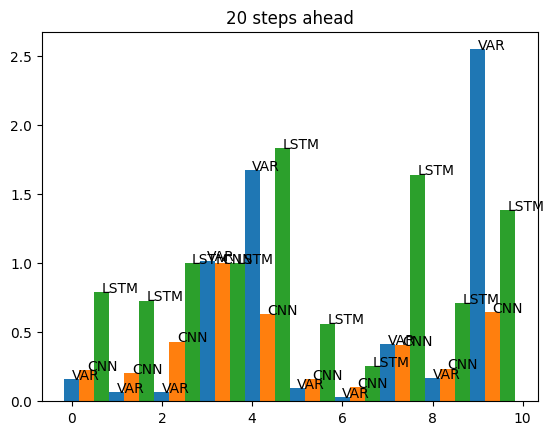

In [6]:
for steps_ahead in steps_ahead_list:
    var_scores = list(var_df[f'VAR_result ({steps_ahead} steps ahead)'].values)
    fig, ax = plt.subplots()
    bar_width = 1/(len(redes)+1)
    ax.set_title(f'{steps_ahead} steps ahead')
    ax.bar(data_indices, var_scores, bar_width, label="VAR")
    for x, y in zip(data_indices, var_scores):
        plt.annotate("VAR", (x, y))
    for index, rede in enumerate(redes):
        current_x_axis = [x+bar_width*(index+1) for x in data_indices]
        current_net_scores = list(datasets[rede][steps_ahead].groupby('data_set_index')['score'].min().values)
        ax.bar(current_x_axis, current_net_scores, bar_width, label=rede)
        for x, y in zip(current_x_axis, current_net_scores):
            plt.annotate(rede, (x, y))
    plt.show()

In [7]:
var_summary = pd.DataFrame({'média': var_df.mean(), 'desvio': var_df.std()}).iloc[1:]
var_summary

,média,desvio
VAR_result (1 steps ahead),0.162287,0.208111
VAR_result (5 steps ahead),0.323938,0.429947
VAR_result (20 steps ahead),0.624475,0.863060


In [9]:
from scipy.stats import mannwhitneyu
nets_summaries = {}
for rede in redes:
    nets_summaries[rede] = {}
    for steps_ahead in steps_ahead_list:
        best_scores_opt = datasets[rede][steps_ahead].groupby('data_set_index')['score'].min()
        nets_summaries[rede][steps_ahead] = pd.Series({
            'Média': best_scores_opt.mean(), 'Desvio': best_scores_opt.std()
        })
        print(rede)
        print(f"{steps_ahead} passos à frente")
        print(nets_summaries[rede][steps_ahead])
        print("TESTE DE MANN-WHITNEY COMPARANDO COM O VAR")
        alpha = 0.05
        U1, p = mannwhitneyu(best_scores_opt.values, var_df[f"VAR_result ({steps_ahead} steps ahead)"].values)
        nx, ny = len(best_scores_opt.values), var_df.shape[0]
        U2 = nx*ny - U1
        U = min(U1, U2)
        print(f"Estatística de teste: U={U}")
        if p < alpha:
            print(f"Pelo teste de Mann-Whitney as amostras não seguem a mesma distribuição com nível de significância α={alpha}")
        else:
            print(f"Pelo teste de Mann-Whitney com nível de significância α={alpha} não há evidência suficiente para dizer que as distribuições não sejam iguais")

CNN
1 passos à frente
Média     0.462484
Desvio    0.332204
dtype: float64
TESTE DE MANN-WHITNEY COMPARANDO COM O VAR
Estatística de teste: U=17.0
Pelo teste de Mann-Whitney as amostras não seguem a mesma distribuição com nível de significância α=0.05
CNN
5 passos à frente
Média     0.464159
Desvio    0.336657
dtype: float64
TESTE DE MANN-WHITNEY COMPARANDO COM O VAR
Estatística de teste: U=29.0
Pelo teste de Mann-Whitney com nível de significância α=0.05 não há evidência suficiente para dizer que as distribuições não sejam iguais
CNN
20 passos à frente
Média     0.404378
Desvio    0.282479
dtype: float64
TESTE DE MANN-WHITNEY COMPARANDO COM O VAR
Estatística de teste: U=40.0
Pelo teste de Mann-Whitney com nível de significância α=0.05 não há evidência suficiente para dizer que as distribuições não sejam iguais
LSTM
1 passos à frente
Média     0.959668
Desvio    0.456181
dtype: float64
TESTE DE MANN-WHITNEY COMPARANDO COM O VAR
Estatística de teste: U=2.0
Pelo teste de Mann-Whitney as 